## Block de code 1

In [1]:
import numpy as np
import os
import time
%matplotlib inline
import matplotlib.pyplot as mp
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as om
import torchvision as tv
import torch.utils.data as dat

if torch.cuda.is_available():     # Make sure GPU is available
    dev = torch.device("cuda:0")
    kwar = {'num_workers': 8, 'pin_memory': True}
    cpu = torch.device("cpu")
else:
    print("Warning: CUDA not found, CPU only.")
    dev = torch.device("cpu")
    kwar = {}
    cpu = torch.device("cpu")

np.random.seed(551)


## Imlporter les données et créer le dataset

### Block de code 2

In [2]:
dataDir = 'resized'               # Le répertoire de données principal
classNames = os.listdir(dataDir)  # Chaque type d'image se trouve dans son propre sous-répertoire
numClass = len(classNames)        # Nombre de types = nombre de sous-répertoires
imageFiles = [[os.path.join(dataDir,classNames[i],x) for x in os.listdir(os.path.join(dataDir,classNames[i]))]
              for i in range(numClass)]                     # Une liste imbriquée de noms de fichiers
numEach = [len(imageFiles[i]) for i in range(numClass)]     # Un décompte de chaque type d'image
imageFilesList = []               # Création d'une liste non imbriquée de noms de fichiers
imageClass = []                   # Les étiquettes -- le type de chaque image individuelle dans la liste
for i in range(numClass):
    imageFilesList.extend(imageFiles[i])
    imageClass.extend([i]*numEach[i])
numTotal = len(imageClass)        # Nombre total d'images
imageWidth, imageHeight = Image.open(imageFilesList[0]).size         #Les dimensions de chaque image

print("There are",numTotal,"images in",numClass,"distinct categories")
print("Label names:",classNames)
print("Label counts:",numEach)
print("Image dimensions:",imageWidth,"x",imageHeight)

There are 58954 images in 6 distinct categories
Label names: ['AbdomenCT', 'BreastMRI', 'ChestCT', 'CXR', 'Hand', 'HeadCT']
Label counts: [10000, 8954, 10000, 10000, 10000, 10000]
Image dimensions: 64 x 64


## Block de code 3 : 
- Prendre des images aléatoirement les labeliser et les visualiser

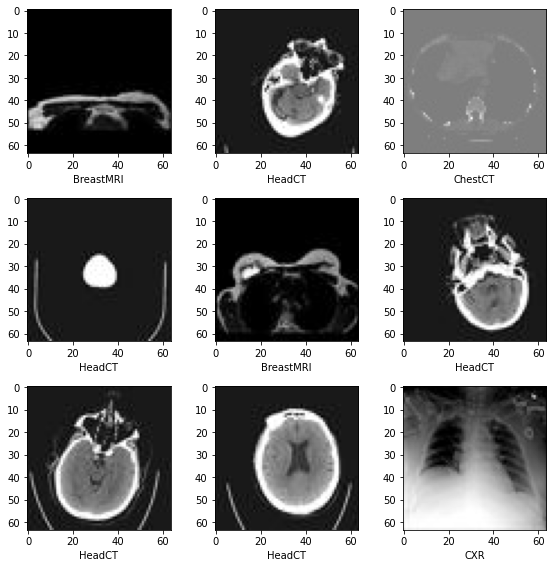

In [3]:
mp.subplots(3,3,figsize=(8,8))
for i,k in enumerate(np.random.randint(numTotal, size=9)):  # Take a random sample of 9 images and
    im = Image.open(imageFilesList[k])                      #      plot and label them
    arr = np.array(im)
    mp.subplot(3,3,i+1)
    mp.xlabel(classNames[imageClass[k]])
    mp.imshow(arr,cmap='gray',vmin=0,vmax=255)
mp.tight_layout()
mp.show()

## Transformer les données et le partitionnement en ensembles d'apprentissage, de validation et de test
## Block de code 4

In [4]:
# Normaliser les pixels des images [(y-min)/(y-max)]-mean()
toTensor = tv.transforms.ToTensor()#transforme les images en pixels
def scaleImage(x):          # Passer une image PIL, retourner un tenseur
    y = toTensor(x)
    if(y.min() < y.max()):  # En supposant que l'image n'est pas vide, redimensionnez pour que ses valeurs passent de 0 à 1
        y = (y - y.min())/(y.max() - y.min()) 
    z = y - y.mean()        # Soustraire la valeur moyenne de l'image
    return z


## Block code 5
Avec la fonction de transformation image en tenseur définie, nous créons maintenant un tenseur maître à partir de toutes ces images. Nous créons également un tenseur pour les étiquettes. L'exécution de ce code prend un moment. Nous vérifions la plage finale des valeurs de pixels mises à l'échelle et vérifions que la moyenne est (pratiquement) nulle.

In [5]:
imageTensor = torch.stack([scaleImage(Image.open(x)) for x in imageFilesList])  # Load, scale, and stack image (X) tensor
classTensor = torch.tensor(imageClass)  # Create label (Y) tensor
print("Rescaled min pixel value = {:1.3}; Max = {:1.3}; Mean = {:1.3}".format(imageTensor.min().item(),imageTensor.max().item(),imageTensor.mean().item()))

Rescaled min pixel value = -0.786; Max = 0.972; Mean = -3.35e-09


## Block de code 6:
Avec tout en ordre jusqu'à présent, nous passons à la partition de ces tenseurs maîtres en trois ensembles de données.

Parce qu'un modèle peut avoir des millions de paramètres libres, il est tout à fait possible qu'il <em>surajuste</em> aux données fournies. C'est-à-dire qu'il peut ajuster ses poids aux valeurs précises nécessaires pour prédire correctement chaque image donnée, mais ne parvient pas à reconnaître même de légères variations sur les images originales, sans parler des toutes nouvelles.

Une solution courante consiste à séparer les données en un ensemble d'entraînement, utilisé pour minimiser la fonction de perte, et un ensemble de validation, évalué séparément pendant l'entraînement sans affecter directement les poids du modèle. Cependant, l'ensemble de validation peut être utilisé pour modifier les <em>hyperparamètres</em> (paramètres extérieurs au modèle régissant son entraînement), sélectionner le meilleur modèle à chaque époque ou influencer indirectement l'entraînement d'une autre manière. Pour cette raison, un troisième ensemble de tests indépendants est généralement créé pour l'évaluation finale une fois la formation terminée.

Parce que plus le modèle voit de données, plus il tend à devenir précis, nous réservons généralement des fractions relativement petites pour la validation et les tests.

PyTorch a un objet <a href="https://pytorch.org/docs/stable/_modules/torch/utils/data/dataset.html">Dataset</a> intégré qui peut simplifier ces étapes lorsque vous travaillez avec plus types de données complexes, mais dans ce cas, ils demanderaient plus d'efforts qu'ils n'en économisent.

Le code ci-dessous affectera au hasard environ 10 % des indices aux listes correspondant aux ensembles de validation et de test. Une fois cela fait, nous pouvons créer ces ensembles de données en découpant l'image principale et les tenseurs d'étiquettes à l'aide de ces listes.

In [6]:
# Création du train test et validation split

validFrac = 0.1   # Define the fraction of images to move to validation dataset
testFrac = 0.1    # Define the fraction of images to move to test dataset
validList = []
testList = []
trainList = []

for i in range(numTotal):
    rann = np.random.random() # Randomly reassign images
    if rann < validFrac:
        validList.append(i)
    elif rann < testFrac + validFrac:
        testList.append(i)
    else:
        trainList.append(i)
        
nTrain = len(trainList)  # Count the number in each set
nValid = len(validList)
nTest = len(testList)
print("Training images =",nTrain,"Validation =",nValid,"Testing =",nTest)


Training images = 47381 Validation = 5833 Testing = 5740


## Block de code 7
nous pouvons maintenant utiliser ces listes pour découper les tenseurs maîtres avec le code ci-dessous. Sinon, nous pouvons réexécuter la cellule ci-dessus avec différentes fractions mises de côté.

In [7]:
trainIds = torch.tensor(trainList)    # Slice the big image and label tensors up into
validIds = torch.tensor(validList)    #       training, validation, and testing tensors
testIds = torch.tensor(testList)
trainX = imageTensor[trainIds,:,:,:]
trainY = classTensor[trainIds]
validX = imageTensor[validIds,:,:,:]
validY = classTensor[validIds]
testX = imageTensor[testIds,:,:,:]
testY = classTensor[testIds]


## Code block 8
Après plusieurs couches convolutives, il est typique d'avoir quelques couches entièrement connectées. Tout d'abord, toutes les informations de la dernière couche sont "aplaties" dans un vecteur. Dans une couche entièrement connectée, des poids relient chaque nœud (endroit pour stocker une valeur) de la couche d'entrée à chaque nœud de la couche de sortie - aucune préférence particulière n'est accordée aux nœuds voisins comme dans les pixels d'une couche convolutive. Les poids multiplient les valeurs dans les nœuds de la couche d'entrée, sont additionnés, puis placés dans un nœud de la couche de sortie. Ceci est répété pour chaque nœud de la couche de sortie.

Maintenant, il y a une étape supplémentaire dans chacun de ceux-ci qui a été omise : l'application de la fonction d'activation. Si la fonction linéaire y = 3x + 2 est composée de z = 4y - 7, alors z est toujours une fonction linéaire de x : z = 12x + 1. La même chose est vraie pour les fonctions linéaires de dimensions supérieures (multiplication par des poids et somme, comme nous l'avons fait). Sans la fonction d'activation, quel que soit le nombre de couches que nous empilons, elle pourrait finalement être remplacée par une seule. Pour éviter cela, à chaque couche de sortie, nous appliquons une fonction d'activation non linéaire. Cela n'a pas besoin d'être la même fonction à chaque couche. Dans cette architecture, nous choisissons les fonctions <a href="http://image-net.org/challenges/posters/JKU_EN_RGB_Schwarz_poster.pdf">ELU</a> , mais il existe de nombreuses autres options populaires, telles que <a href="https://en.wikipedia.org/wiki/Rectifier_(neural_networks)">ReLU</a>.

In [8]:
class MedNet(nn.Module):
    def __init__(self,xDim,yDim,numC): # Pass image dimensions and number of labels when initializing a model   
        super(MedNet,self).__init__()  # Extends the basic nn.Module to the MedNet class
        numConvs1 = 12
        convSize1 = 9
        numConvs2 = 14
        convSize2 = 9
        
        
        numNodesToFC = numConvs2*(xDim-(convSize1-1)-(convSize2-1))*(yDim-(convSize1-1)-(convSize2-1))

        # nn.Conv2d(channels in, channels out, convolution height/width)
        # 1 channel -- grayscale -- feeds into the first convolution. The same number output from one layer must be
        # fed into the next. These variables actually store the weights between layers for the model.
        
        self.cnv1 = nn.Conv2d(1, numConvs1, convSize1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.cnv2 = nn.Conv2d(numConvs1, numConvs2, convSize2)

        # These parameters define the number of output nodes of each fully connected layer.
        # Each layer must output the same number of nodes as the next layer begins with.
        # The final layer must have output nodes equal to the number of labels used.
        #==================================================================================#
        # Ces paramètres définissent le nombre de nœuds de sortie de chaque couche entièrement connectée.
        # Chaque couche doit sortir le même nombre de nœuds que la couche suivante commence.
        # La couche finale doit avoir des nœuds de sortie égaux au nombre d'étiquettes utilisées.
        
        fcSize1 = 400
        fcSize2 = 80
        
        # nn.Linear(nodes in, nodes out)
        # Stores the weights between the fully connected layers
        
        self.ful1 = nn.Linear(numNodesToFC,fcSize1)
        self.ful2 = nn.Linear(fcSize1, fcSize2)
        self.ful3 = nn.Linear(fcSize2,numC)
        
    def forward(self,x):
        # This defines the steps used in the computation of output from input.
        # It makes uses of the weights defined in the __init__ method.
        # Each assignment of x here is the result of feeding the input up through one layer.
        # Here we use the activation function elu, which is a smoother version of the popular relu function.
        
        x = F.elu(self.cnv1(x)) # Feed through first convolutional layer, then apply activation
        x = F.elu(self.cnv2(x)) # Feed through second convolutional layer, apply activation
        x = x.view(-1,self.num_flat_features(x)) # Flatten convolutional layer into fully connected layer
        x = F.elu(self.ful1(x)) # Feed through first fully connected layer, apply activation
        x = F.elu(self.ful2(x))# Feed through second FC layer, apply output 
        x = self.ful3(x)        # Final FC layer to output. No activation, because it's used to calculate loss
        return x

    def num_flat_features(self, x):  # Count the individual nodes in a layer
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [ ]:
class MedNet(nn.Module):
    def __init__(self,xDim,yDim,numC): # Pass image dimensions and number of labels when initializing a model   
        super(MedNet,self).__init__()  # Extends the basic nn.Module to the MedNet class
        # The parameters here define the architecture of the convolutional portion of the CNN. Each image pixel
        # has numConvs convolutions applied to it, and convSize is the number of surrounding pixels included
        # in each convolution. Lastly, the numNodesToFC formula calculates the final, remaining nodes at the last
        # level of convolutions so that this can be "flattened" and fed into the fully connected layers subsequently.
        # Each convolution makes the image a little smaller (convolutions do not, by default, "hang over" the edges
        # of the image), and this makes the effective image dimension decreases.
        
        #=======================================================================================================================#
        # Passer les dimensions de l'image et le nombre d'étiquettes lors de l'initialisation d'un modèle
        # Étend le nn.Module de base à la classe MedNet
        # Les paramètres définissent ici l'architecture de la partie convolutive du CNN. Chaque pixel de l'image
        # a numConvs convolutions appliquées, et convSize est le nombre de pixels environnants inclus
        # dans chaque circonvolution. Enfin, la formule numNodesToFC calcule les derniers nœuds restants au dernier
        # niveau de convolutions afin que cela puisse être "aplati" et introduit ultérieurement dans les couches entièrement connectées.
        # Chaque convolution rend l'image un peu plus petite (les convolutions ne "pendent pas" par défaut sur les bords
        # de l'image), ce qui fait que la dimension effective de l'image diminue.
        #===========================================================================================================#
        numConvs1 = 12
        convSize1 = 9
        numConvs2 = 14
        convSize2 = 9
        
        
        numNodesToFC = numConvs2*(xDim-(convSize1-1)-(convSize2-1))*(yDim-(convSize1-1)-(convSize2-1))

        # nn.Conv2d(channels in, channels out, convolution height/width)
        # 1 channel -- grayscale -- feeds into the first convolution. The same number output from one layer must be
        # fed into the next. These variables actually store the weights between layers for the model.
        
        self.cnv1 = nn.Conv2d(1, numConvs1, convSize1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.cnv2 = nn.Conv2d(numConvs1, numConvs2, convSize2)

        # These parameters define the number of output nodes of each fully connected layer.
        # Each layer must output the same number of nodes as the next layer begins with.
        # The final layer must have output nodes equal to the number of labels used.
        #==================================================================================#
        # Ces paramètres définissent le nombre de nœuds de sortie de chaque couche entièrement connectée.
        # Chaque couche doit sortir le même nombre de nœuds que la couche suivante commence.
        # La couche finale doit avoir des nœuds de sortie égaux au nombre d'étiquettes utilisées.
        
        fcSize1 = 400
        fcSize2 = 80
        
        # nn.Linear(nodes in, nodes out)
        # Stores the weights between the fully connected layers
        
        self.ful1 = nn.Linear(numNodesToFC,fcSize1)
        self.ful2 = nn.Linear(fcSize1, fcSize2)
        self.ful3 = nn.Linear(fcSize2,numC)
        
    def forward(self,x):
        # This defines the steps used in the computation of output from input.
        # It makes uses of the weights defined in the __init__ method.
        # Each assignment of x here is the result of feeding the input up through one layer.
        # Here we use the activation function elu, which is a smoother version of the popular relu function.
        
        x = F.elu(self.cnv1(x)) # Feed through first convolutional layer, then apply activation
        x = F.elu(self.cnv2(x)) # Feed through second convolutional layer, apply activation
        x = x.view(-1,self.num_flat_features(x)) # Flatten convolutional layer into fully connected layer
        x = F.elu(self.ful1(x)) # Feed through first fully connected layer, apply activation
        x = F.elu(self.ful2(x))# Feed through second FC layer, apply output 
        x = self.ful3(x)        # Final FC layer to output. No activation, because it's used to calculate loss
        return x

    def num_flat_features(self, x):  # Count the individual nodes in a layer
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

## Block de code 9

In [9]:
model = MedNet(imageWidth,imageHeight,numClass).to(dev)
model

MedNet(
  (cnv1): Conv2d(1, 12, kernel_size=(9, 9), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnv2): Conv2d(12, 14, kernel_size=(9, 9), stride=(1, 1))
  (ful1): Linear(in_features=32256, out_features=400, bias=True)
  (ful2): Linear(in_features=400, out_features=80, bias=True)
  (ful3): Linear(in_features=80, out_features=6, bias=True)
)

## Train le model
## Block de code 10

- origine : 
            {numconv1 =5
             numconv2=10
             convSize1=convSize2=7
             t2vratio =1.2
             batchsize = 300
             maxepoque=20
1 - avec t2vRatio = 2.2, batchSize =250, max epoque = 30, nconv1=9, numconv2=12, convSize1=convSize2=9 on a eu 16 images non classé

2 - parametre 1 + changement de l'optimizer de om SGD à adam avec learning rate =0.001
3-arrivé a 12 mal classé avec les paramaetres mais convsize=9 

si ça ne marche pas remplacer convsize = 9

In [13]:
learnRate = 0.0001        # Define a learning rate.
maxEpochs = 20         # Maximum training epochs
t2vRatio = 2.2       # Maximum allowed ratio of validation to training loss
t2vEpochs = 3            # Number of consecutive epochs before halting if validation loss exceeds above limit
batchSize = 50           # Batch size. Going too large will cause an out-of-memory error.
trainBats = nTrain // batchSize       # Number of training batches per epoch. Round down to simplify last batch
validBats = nValid // batchSize       # Validation batches. Round down
testBats = -(-nTest // batchSize)     # Testing batches. Round up to include all
CEweights = torch.zeros(numClass)     # This takes into account the imbalanced dataset.
for i in trainY.tolist():             #      By making rarer images count more to the loss, 
    CEweights[i].add_(1)              #      we prevent the model from ignoring them.
CEweights = 1. / CEweights.clamp_(min=1.)                     # Weights should be inversely related to count
CEweights = (CEweights * numClass / CEweights.sum()).to(dev)  # The weights average to 1
opti = om.Adam(model.parameters(), lr = learnRate)   # Initialize an optimizer


for i in range(maxEpochs):
    model.train()                     # Set model to training mode
    epochLoss = 0.
    permute = torch.randperm(nTrain)  # Shuffle data to randomize batches
    trainX = trainX[permute,:,:,:]
    trainY = trainY[permute]
    for j in range(trainBats):        # Iterate over batches
        opti.zero_grad()              # Zero out gradient accumulated in optimizer
        batX = trainX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)   # Slice shuffled data into batches
        batY = trainY[j*batchSize:(j+1)*batchSize].to(dev)         # .to(dev) moves these batches to the GPU
        yOut = model(batX)            # Evalute predictions
        loss = F.cross_entropy(yOut, batY,weight=CEweights)        # Compute loss
        epochLoss += loss.item()      # Add loss
        loss.backward()               # Backpropagate loss
        opti.step()                   # Update model weights using optimizer
    validLoss = 0.
    permute = torch.randperm(nValid)  # We go through the exact same steps, without backprop / optimization
    validX = validX[permute,:,:,:]    # in order to evaluate the validation loss
    validY = validY[permute]
    model.eval()                      # Set model to evaluation mode
    with torch.no_grad():             # Temporarily turn off gradient descent
        for j in range(validBats):
            opti.zero_grad()
            batX = validX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)
            batY = validY[j*batchSize:(j+1)*batchSize].to(dev)
            yOut = model(batX)
            validLoss += F.cross_entropy(yOut, batY,weight=CEweights).item()
    epochLoss /= trainBats            # Average loss over batches and print
    validLoss /= validBats
    print("Epoch = {:-3}; Training loss = {:.4f}; Validation loss = {:.4f}".format(i,epochLoss,validLoss))
    if validLoss > t2vRatio * epochLoss:
        t2vEpochs -= 1                # Test if validation loss exceeds halting threshold
        if t2vEpochs < 1:
            print("Validation loss too high; halting to prevent overfitting")
            break

Epoch =   0; Training loss = 0.0013; Validation loss = 0.0067
Epoch =   1; Training loss = 0.0002; Validation loss = 0.0074
Epoch =   2; Training loss = 0.0000; Validation loss = 0.0067
Validation loss too high; halting to prevent overfitting


In [11]:
train_loss = [ 0.0685,0.0161,0.0099,0.0090,0.0049,0.0056, 0.0034,0.0045,0.0030,0.0025]

valid_loss = [0.0334,0.0194,0.0126,0.0122,0.0094,0.0077,0.0096,0.0076,0.0163,0.0112]

In [14]:
confuseMtx = np.zeros((numClass,numClass),dtype=int)    # Create empty confusion matrix
model.eval()
with torch.no_grad():
    permute = torch.randperm(nTest)                     # Shuffle test data
    testX = testX[permute,:,:,:]
    testY = testY[permute]
    for j in range(testBats):                           # Iterate over test batches
        batX = testX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)
        batY = testY[j*batchSize:(j+1)*batchSize].to(dev)
        yOut = model(batX)                              # Pass test batch through model
        pred = yOut.max(1,keepdim=True)[1]              # Generate predictions by finding the max Y values
        for j in torch.cat((batY.view_as(pred), pred),dim=1).tolist(): # Glue together Actual and Predicted to
            confuseMtx[j[0],j[1]] += 1                  # make (row, col) pairs, and increment confusion matrix
correct = sum([confuseMtx[i,i] for i in range(numClass)])   # Sum over diagonal elements to count correct predictions
print("Correct predictions: ",correct,"of",nTest)
print("Confusion Matrix:")
print("Accuracy = ",correct/nTest)
print('                                                  ')
print("Nombre d'images mal prédite est : ",nTest - correct)
print('                                                  ')
print(confuseMtx)
print('                                                  ')
print(classNames)

Correct predictions:  5733 of 5740
Confusion Matrix:
Accuracy =  0.998780487804878
                                                  
Nombre d'images mal prédite est :  7
                                                  
[[972   0   0   0   0   0]
 [  0 898   0   0   0   0]
 [  0   0 992   0   0   0]
 [  0   0   0 961   2   0]
 [  0   0   1   2 934   2]
 [  0   0   0   0   0 976]]
                                                  
['AbdomenCT', 'BreastMRI', 'ChestCT', 'CXR', 'Hand', 'HeadCT']


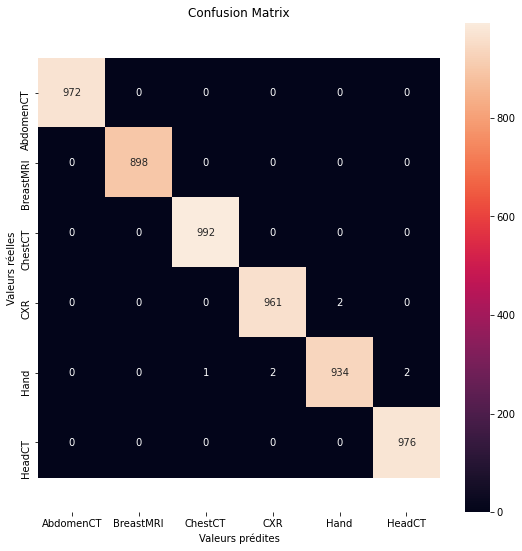

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=(9,9))
# Matrice de confusion
ax= plt.subplot()
sns.heatmap(confuseMtx, annot=True, ax = ax ,fmt='g'); #annot=True to annotate cells
ax.set_xlabel('Valeurs prédites');ax.set_ylabel('Valeurs réelles'); 
ax.set_title('Confusion Matrix'); 
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.xaxis.set_ticklabels(['AbdomenCT', 'BreastMRI', 'ChestCT', 'CXR', 'Hand', 'HeadCT']); ax.yaxis.set_ticklabels(['AbdomenCT', 'BreastMRI', 'ChestCT', 'CXR', 'Hand', 'HeadCT']);


In [42]:
import matplotlib.pyplot as plt

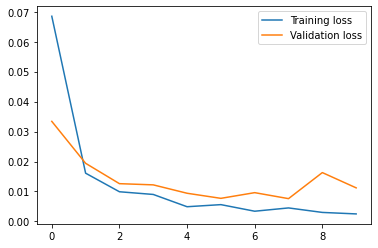

In [46]:
#plotting the training and validation loss
plt.plot(train_loss, label='Training loss')
plt.plot(valid_loss, label='Validation loss')
plt.legend()
plt.show()

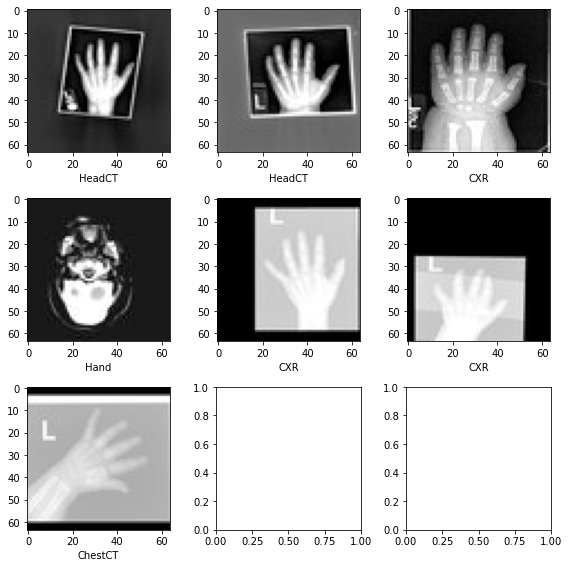

In [47]:
def scaleBack(x):               # Pass a tensor, return a numpy array from 0 to 1
    if(x.min() < x.max()):      # Assuming the image isn't empty, rescale so its values run from 0 to 1
        x = (x - x.min())/(x.max() - x.min())
    return x[0].to(cpu).numpy() # Remove channel (grayscale anyway)

model.eval()
mp.subplots(3,3,figsize=(8,8))
imagesLeft = 9
permute = torch.randperm(nTest)        # Shuffle test data
testX = testX[permute,:,:,:]
testY = testY[permute]
for j in range(testBats):              # Iterate over test batches
    batX = testX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)
    batY = testY[j*batchSize:(j+1)*batchSize].to(dev)
    yOut = model(batX)                 # Pass test batch through model
    pred = yOut.max(1)[1].tolist()     # Generate predictions by finding the max Y values
    for i, y in enumerate(batY.tolist()):
        if imagesLeft and y != pred[i]:         # Compare the actual y value to the prediction
            imagesLeft -= 1
            mp.subplot(3,3,9-imagesLeft)
            mp.xlabel(classNames[pred[i]])      # Label image with what the model thinks it is
            mp.imshow(scaleBack(batX[i]),cmap='gray',vmin=0,vmax=1)
mp.tight_layout()
mp.show()

In [48]:
pwd

'C:\\Users\\Utilisateur\\Desktop\\classification image medicales\\Medical-MNIST-Classification'

In [50]:
#ls

In [51]:
torch.save(model, 'new_model')